In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield_car = leadfield - leadfield.mean(axis=0)
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 19.04it/s]

Using control points [0.00000000e+00 3.42001891e-10 3.25860550e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


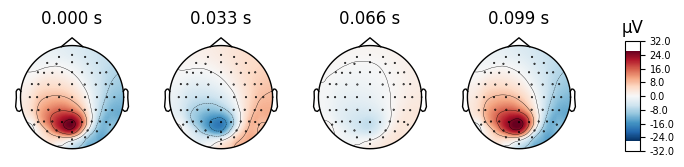

In [177]:
%matplotlib qt

# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=2, extents=25, duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

evoked.plot_topomap()

# Algo

## Helper functions

In [168]:
def thresholding(x, k):
    if type(x) == list:
        x = np.array(x)
    highest_idc = np.argsort(abs(x))[-k:]
    # print(highest_idc)
    x_new = np.zeros(len(x))
    x_new[highest_idc] = x[highest_idc]
    return x_new

def calc_residual_variance(M_hat, M):
        return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)

def euclidean_distance(A, B):
    ''' Euclidean Distance between two points.'''
    return np.sqrt(np.sum((A-B)**2))
def calc_area_tri(AB, AC, CB):
    ''' Calculates area of a triangle given the length of each side.'''
    s = (AB + AC + CB) / 2
    area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5
    return area
def find_corner(source_power, residual):
    ''' Find the corner of the l-curve given by plotting regularization
    levels (r_vals) against norms of the inverse solutions (l2_norms).

    Parameters
    ----------
    r_vals : list
        Levels of regularization
    l2_norms : list
        L2 norms of the inverse solutions per level of regularization.
    
    Return
    ------
    idx : int
        Index at which the L-Curve has its corner.

    
    '''
    
    # Normalize l2 norms

    A = np.array([residual[0], source_power[0]])
    C = np.array([residual[-1], source_power[-1]])
    areas = []
    for j in range(1, len(source_power)-1):
        B = np.array([residual[j], source_power[j]])
        AB = euclidean_distance(A, B)
        AC = euclidean_distance(A, C)
        CB = euclidean_distance(C, B)
        area = abs(calc_area_tri(AB, AC, CB))
        areas.append(area)
    if len(areas) > 0:
        idx = np.argmax(areas)+1
    else:
        idx = 0
    return idx

## Orthogonal Matching Pursuit

In [132]:
K = 1
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
r = deepcopy(y[:, 0])
residuals = np.array([np.linalg.norm(y[:, 0] - leadfield@x_hat), ])
source_norms = np.array([0,])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])

x_hats = [deepcopy(x_hat), ]
for i in range(max_iter):
    b = leadfield.T @ r
    b_thresh = thresholding(b, K)
    omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
    omega = omega.astype(int)
    # print(omega)
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @y[:, 0]
    r = y[:, 0] - leadfield@x_hat
    x_hats.append(deepcopy(x_hat))

    y_hat = leadfield@x_hat
    residuals = np.append(residuals, np.linalg.norm(y[:, 0] - y_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y_hat, y[:, 0]))
    

iters = np.arange(len(residuals)).astype(float)
corner_idx = find_corner(iters[1:], unexplained_variance[1:])+1
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(iters, unexplained_variance, '*k')
plt.xlabel("iter")
plt.ylabel("EEG unexplained_variance")
plt.plot(iters[corner_idx], unexplained_variance[corner_idx], 'or')

## CoSaMP

In [15]:
K = 25
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
b = np.zeros((n_dipoles, ))

omega = np.array([])
r = deepcopy(y[:, 0])
leadfield_pinv = np.linalg.pinv(leadfield)

residuals = np.array([np.linalg.norm(y[:, 0] - leadfield@x_hat), ])
source_norms = np.array([0,])
x_hats = [deepcopy(x_hat), ]
for i in range(1, max_iter+1):
    e = leadfield.T @ r
    e_thresh = thresholding(e, 2*K)
    omega = np.where(e_thresh!=0)[0]
    old_activations = np.where(x_hats[i-1]!=0)[0]
    T = np.unique(np.concatenate([omega, old_activations]))
    leadfield_pinv = np.linalg.pinv(leadfield[:, T])
    b[T] = leadfield_pinv @ y[:, 0]
    x_hat = thresholding(b, K)
    r = y[:, 0] - leadfield@x_hat
    
    residuals = np.append(residuals, np.linalg.norm(y[:, 0] - leadfield@x_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append(deepcopy(x_hat))
    if residuals[-1] == residuals[-2]:
        break


    
corner_idx = find_corner(source_norms, residuals)
x_hat = x_hats[corner_idx]


# plt.figure()
# plt.plot(source_norms, residuals, '*k')
# plt.xlabel("Source Power")
# plt.ylabel("EEG Residual")
# plt.plot(source_norms[corner_idx], residuals[corner_idx], 'or')
# plt.title(f"Idx {corner_idx}")

# Simultaneous Orthogonal Matching Pursuit

In [5]:
n_time = y.shape[1]
max_iter = n_chans
leadfield_pinv = np.linalg.pinv(leadfield)
x_hat = np.zeros((n_dipoles, n_time))
x_hats = [deepcopy(x_hat)]
residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
unexplained_variance = np.array([calc_residual_variance(y, leadfield@x_hat),])
source_norms = np.array([0,])

R = deepcopy(y)
omega = np.array([])
q = 1
for i in range(max_iter):
    b_n = np.linalg.norm(leadfield.T@R, axis=1, ord=q)

    # if len(omega)>0:
    #     b_n[omega] = 0

    b_thresh = thresholding(b_n, 1)
    omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
    omega = np.unique(omega.astype(int))
    leadfield_pinv = np.linalg.pinv(leadfield[:, omega])
    x_hat[omega] = leadfield_pinv @ y
    R = y - leadfield@x_hat
    
    residuals = np.append(residuals, np.linalg.norm(R))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y, leadfield@x_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append( deepcopy(x_hat) )

unexplained_variance[0] = unexplained_variance[1]
iters = np.arange(len(residuals))
corner_idx = find_corner(residuals, iters)
x_hat = x_hats[corner_idx]

plt.figure()
plt.plot(iters, residuals, "*k")
plt.plot(iters[corner_idx], residuals[corner_idx], "or")
plt.xlabel("Iteration No.")
plt.ylabel("Residual")
plt.title(corner_idx)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_12160\1405858178.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)


Text(0.5, 1.0, '32')

In [7]:

plt.figure()
plt.plot(iters, residuals, "*k")
plt.plot(iters[corner_idx], residuals[corner_idx], "or")
plt.xlabel("Iteration No.")
plt.ylabel("Residual")
plt.title(corner_idx)

Text(0.5, 1.0, '32')

# Iterative Hard Thresholding

In [39]:
K = 10

residuals = np.array([np.linalg.norm(y[:, 0] - leadfield@x_hat), ])
source_norms = np.array([0,])
leadfield_pinv = np.linalg.pinv(leadfield)
x_hats = [np.zeros(n_dipoles) ]
for i in range(1, n_chans+1):
    r = y[:, 0] - leadfield@x_hats[i-1]
    # x_hats.append( thresholding(x_hats[i-1] + leadfield.T @ r, K) )
    x_hats.append( thresholding(x_hats[i-1] + leadfield_pinv @ r, K) )
    
    residuals = np.append(residuals, np.linalg.norm(y[:, 0] - leadfield@x_hats[-1]))
    source_norms = np.append(source_norms, np.linalg.norm(x_hats[-1]))

    # x_hats.append(deepcopy(x_hat))

corner_idx = find_corner(source_norms[1:], residuals[1:])+1
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(source_norms, residuals, '*k')
plt.xlabel("Source Power")
plt.ylabel("EEG Residual")
plt.plot(source_norms[corner_idx], residuals[corner_idx], 'or')
plt.title(corner_idx)

Text(0.5, 1.0, '6')

# Reduce MMV and boost

In [178]:
def calc_omp_solution(y, leadfield, K=1):
    """ Calculates the Orthogonal Matching Pursuit (OMP) inverse solution.
    
    Parameters
    ----------
    y : numpy.ndarray
        The data matrix (channels,).
    
    Return
    ------
    x_hat : numpy.ndarray
        The inverse solution (dipoles,)
    """
    n_chans = len(y)
    _, n_dipoles = leadfield.shape

    leadfield_pinv = np.linalg.pinv(leadfield)
    x_hat = np.zeros(n_dipoles)
    x_hats = [deepcopy(x_hat)]
    # unexplained_variance = np.array([calc_residual_variance(y, leadfield@x_hat),])
    source_norms = np.array([0,])

    x_hat = np.zeros((n_dipoles, ))
    omega = np.array([])
    r = deepcopy(y)
    residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
    source_norms = np.array([0,])
    x_hats = [deepcopy(x_hat), ]

    for i in range(n_chans):
        b = leadfield.T @ r
        b_thresh = thresholding(b, K)
        omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
        omega = omega.astype(int)

        x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @ y
        r = y - leadfield@x_hat

        residuals = np.append(residuals, np.linalg.norm(y - leadfield@x_hat))
        source_norms = np.append(source_norms, np.sum(x_hat**2))
        x_hats.append(deepcopy(x_hat))


        
    iters = np.arange(len(residuals)).astype(float)
    corner_idx = find_corner(iters, residuals)
    x_hat = x_hats[corner_idx]
    return x_hat
    

K = 1
rand = np.random.rand
n_time = y.shape[1]
residuals = np.array([np.linalg.norm(y - np.zeros(y.shape)), ])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])
source_norms = np.array([0,])
n_sources = np.array([0,])
S_hats = np.array([])
x_hats = [np.zeros((n_dipoles, n_time))]
for i in range(n_chans):
    a = rand(n_time)
    y_vec = y@a
    x_hat = calc_omp_solution(y_vec, leadfield, K=K)
    S_hat = np.where(x_hat!=0)[0].astype(int)
    # S_hats = np.unique( np.append(S_hats, S_hat) ).astype(int)
    As_pinv = np.linalg.pinv(leadfield[:, S_hat])
    # As_pinv = np.linalg.pinv(leadfield)[S_hat]


    x_hat = np.zeros((n_dipoles, n_time))
    x_hat[S_hat, :] = As_pinv @ y
    # x_hat[S_hats, :] = As_pinv @ y
    x_hats.append( x_hat )
    
    residuals = np.append(residuals, np.linalg.norm(y-leadfield@x_hat))
    source_norms = np.append(source_norms, np.linalg.norm(x_hat))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(leadfield@x_hat, y))
    n_sources = np.append(n_sources, len(S_hat)).astype(float)

iters = np.arange(len(unexplained_variance)).astype(float)

idc = np.argsort(n_sources)
n_sources = n_sources[idc]
unexplained_variance = unexplained_variance[idc]

corner_idx = find_corner(n_sources, unexplained_variance)
corner_idx = idc[corner_idx]
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(n_sources, unexplained_variance, '*k')
plt.xlabel("n_sources")
plt.ylabel("EEG unexplained_variance")
plt.plot(n_sources[corner_idx], unexplained_variance[corner_idx], 'or')
plt.title(corner_idx)

Text(0.5, 1.0, '50')

# Plot

Using control points [0.00000000e+00 0.00000000e+00 6.36246437e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


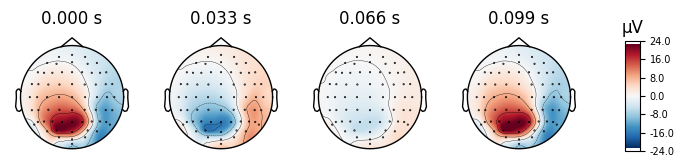

Using control points [0.00000000e+00 5.09514118e-10 4.02223137e-08]


In [179]:
%matplotlib qt
stc_ = stc.copy()
# stc_.data[:, 0] = x_hat / abs(x_hat).max()
stc_.data = x_hat

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Estimation', 'title',
               font_size=14)

eeg = leadfield @ x_hat
evoked = mne.EvokedArray(eeg, info)
evoked.plot_topomap()